In [1]:
! pip install scikit-learn openTSNE torch_dct

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.8 MB/s eta 0:00:00 0:00:01m
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import numpy as np
import importlib
import random

import copy
import torch
from torch.utils.data import DataLoader

from utils.common import load_config, setup_seed
from data.dataset import ImageDataset
from models.models import Simple_CNN
from models.augment_network import SingleLayer

# from MulticoreTSNE import MulticoreTSNE as TSNE
from openTSNE import TSNE  # 直接导入 openTSNE 的 TSNE 类

import matplotlib.pyplot as plt

In [3]:
def get_feature(model, dataloader, config, device):
    model.eval()
    Loss = importlib.import_module('loss.'+config.loss)
    criterion = getattr(Loss, config.loss)(config)
    criterion = criterion.to(device)

    with torch.no_grad():
        features = []
        labels =[]
        probs=[]
        for i, batch in enumerate(dataloader):
            input_img_batch, label_batch, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)
            label = label_batch.reshape((-1)).to(device)
            prob, feature = model(input_img, data='dct')
            prob, _ = criterion(feature, prob)

            if i == 0:
                probs = prob
                gt_labels = label
                features = feature
            else:
                probs = torch.cat([probs, prob], dim=0)
                gt_labels = torch.cat([gt_labels, label])
                features=torch.cat(([features, feature]))

    features = features.cpu().numpy()
    probs = probs.cpu().numpy()
    labels = gt_labels.cpu().numpy()
        
    return features, labels, probs

In [5]:
def get_aug_feature(model, augnets, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_img_batch, _, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)

            aug_imgs = []
            augnet_labels = []
            for idx, augnet in enumerate(augnets): 
                augnet.eval()
                aug_img = augnet(input_img)
                aug_imgs.append(aug_img)
                aug_label = idx * torch.ones(len(input_img))
                augnet_labels.append(aug_label)
                
            aug_imgs = torch.cat(aug_imgs)
            augnet_labels=torch.cat(augnet_labels)

            prob, feature = model(input_img, data='dct')
            aug_prob, aug_feature = model(aug_imgs, data='dct')
            
            if i == 0:
                all_augnet_labels = augnet_labels.cpu().numpy()
                features = feature.cpu().numpy()
                aug_features = aug_feature.cpu().numpy()
            else:
                all_augnet_labels = np.hstack([all_augnet_labels, augnet_labels.cpu().numpy()])
                features=np.vstack((features, feature.cpu().numpy()))
                aug_features = np.vstack((aug_features, aug_feature.cpu().numpy()))

    return features, aug_features, all_augnet_labels

In [6]:
def tsne_analyze(features, labels, legends):
    print(f">>> t-SNE fitting")
    embeddings = TSNE(n_jobs=4).fit(features)
    print(f"<<< fitting over")
    indexs = [i for i in range(len(embeddings))]
    random.shuffle(indexs)
    embeddings = np.array([embeddings[indexs[i]] for i in range(len(indexs))])
    labels = [labels[indexs[i]] for i in range(len(indexs))]
    vis_x = embeddings[:, 0]
    vis_y = embeddings[:, 1]

    print(f">>> draw image begin")
    plt.figure(figsize=(8, 8))
    num_classes =  len(set(labels))
    for i, lab in enumerate(list(range(num_classes))):
        class_index = [j for j,v in enumerate(labels) if v == lab]
        if lab == 0:
            plt.scatter(vis_x[class_index], vis_y[class_index], s=40, color = plt.cm.tab20(i), alpha=1, marker='^')
        elif lab == 1:
            plt.scatter(vis_x[class_index], vis_y[class_index], color = plt.cm.tab20(i), alpha=1, marker='o')
        else:
            plt.scatter(vis_x[class_index], vis_y[class_index], color = 'k', alpha=0.5, marker='o')

    plt.xticks([])
    plt.yticks([])
    plt.legend(legends, fontsize=18, loc='upper left')
    print(f"<<< draw image end")

In [7]:
def case_visualization(known_data_path, unknown_data_path, legends):
    close_set = ImageDataset([(os.path.join(known_data_path, img_path), 0) for img_path in os.listdir(known_data_path)], config, balance=False, test_mode=True)
    close_loader = DataLoader(
        dataset=close_set,
        num_workers=config.num_workers,
        batch_size=config.batch_size,
        pin_memory=True,
        shuffle=True,
        drop_last=False,
    )
    out_set = ImageDataset([(os.path.join(unknown_data_path, img_path), 0) for img_path in os.listdir(unknown_data_path)], config, balance=False, test_mode=True)
    out_loader = DataLoader(
        dataset=out_set,
        num_workers=config.num_workers,
        batch_size=config.batch_size,
        pin_memory=True,
        shuffle=True,
        drop_last=False,
    )

    known_feature, aug_feature, aug_label = get_aug_feature(model, augnets, close_loader, device)
    out_feature, out_label, _  = get_feature(model, out_loader, config, device)

    known_label = np.ones(len(known_feature)) * 0
    aug_label = np.ones(len(aug_feature)) * 1
    out_label = np.ones(len(out_feature)) * 2

    tsne_analyze(np.vstack((known_feature,aug_feature,out_feature)), np.hstack((known_label, aug_label, out_label)), legends)

In [10]:
# # device = 'cuda:0'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setup_seed(3)
# config = load_config('configs.{}'.format('progressive'))

# # model_path = './checkpoints/split1/model.pth'
# model_path = '/mnt/workspace/POSE/dataset/models/progressive/0612/POSE_seed0/model_24_test91.75_acc_AUC_80.8_OSCR_77.09646012396702.pth'
# model = Simple_CNN(class_num=11, out_feature_result=True)
# pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
# model.load_state_dict(pretrained_dict)
# model = model.to(device)

# aug_model_paths = [os.path.join('./checkpoints/split1/models','augnet_{}.pth').format(epoch) for epoch in range(20)]
# augnets = []
# aug_network = SingleLayer(inc=32)
# for model_path in aug_model_paths:
#     augnet = copy.deepcopy(aug_network) 
#     augnet.load_state_dict(torch.load(model_path, map_location='cpu')['state_dict'])
#     augnet = augnet.to(device)
#     augnets.append(augnet)
    
from tqdm import tqdm

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
setup_seed(3)
config = load_config('configs.{}'.format('progressive'))

# 主模型加载（添加进度提示）
print("加载主模型...")
model_path = '/mnt/workspace/POSE/dataset/models/progressive/0612/POSE_seed0/model_24_test91.75_acc_AUC_80.8_OSCR_77.09646012396702.pth'
model = Simple_CNN(class_num=11, out_feature_result=True)

# 模拟加载进度
for i in tqdm(range(100), desc="加载主模型权重"):
    if i == 0:
        pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
    # 模拟加载过程中的处理
    if i % 10 == 0:
        pass

model.load_state_dict(pretrained_dict)
model = model.to(device)
print("主模型加载完成！")

# 增强模型加载（使用tqdm显示进度条）
print("\n加载增强模型...")
aug_model_paths = [os.path.join('/mnt/workspace/POSE/dataset/models/progressive/0612/POSE_seed0','augnet_{}.pth').format(epoch) for epoch in range(20,30)]
augnets = []
aug_network = SingleLayer(inc=32)

# 使用tqdm包装迭代器显示进度条
for model_path in tqdm(aug_model_paths, desc="加载增强模型"):
    augnet = copy.deepcopy(aug_network) 
    augnet.load_state_dict(torch.load(model_path, map_location='cpu')['state_dict'])
    augnet = augnet.to(device)
    augnets.append(augnet)

print("所有增强模型加载完成！")

加载主模型...


加载主模型权重: 100%|██████████| 100/100 [00:00<00:00, 3988.23it/s]


主模型加载完成！

加载增强模型...


加载增强模型: 100%|██████████| 10/10 [00:00<00:00, 108.88it/s]

所有增强模型加载完成！


/mnt/workspace/POSE/loss/Softmax.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)  # 计算模型输出的softmax概率分布


>>> t-SNE fitting
<<< fitting over
>>> draw image begin
<<< draw image end


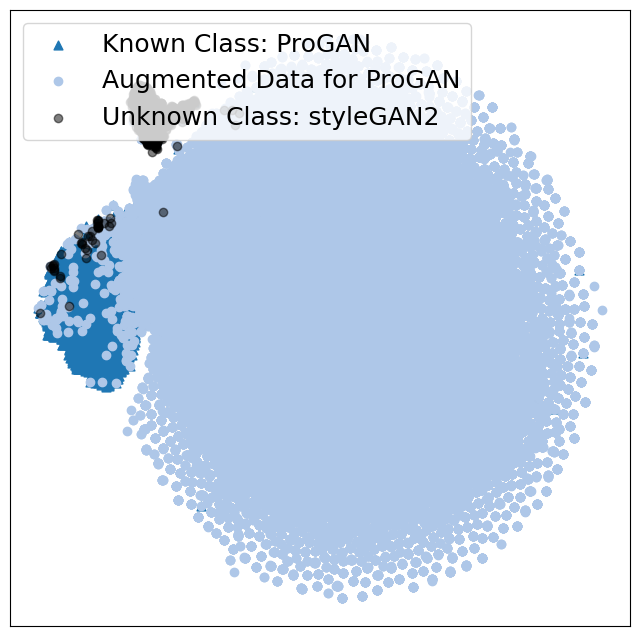

In [11]:
# known_data_path = './dataset/OSMA_subset/fake/styleGAN3/cat'
known_data_path = '/mnt/workspace/POSE/dataset/CNN/GAN/Faces_HQ/ProGAN/train'
# unknown_data_path = './dataset/OSMA_subset/fake/SNGAN/cat'
unknown_data_path = '/mnt/workspace/POSE/dataset/CNN/GAN/Faces_HQ/styleGAN2'
legends = ['Known Class: ProGAN', 'Augmented Data for ProGAN',  'Unknown Class: styleGAN2']
case_visualization(known_data_path, unknown_data_path, legends)

/mnt/workspace/POSE/loss/Softmax.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)  # 计算模型输出的softmax概率分布


>>> t-SNE fitting
<<< fitting over
>>> draw image begin
<<< draw image end


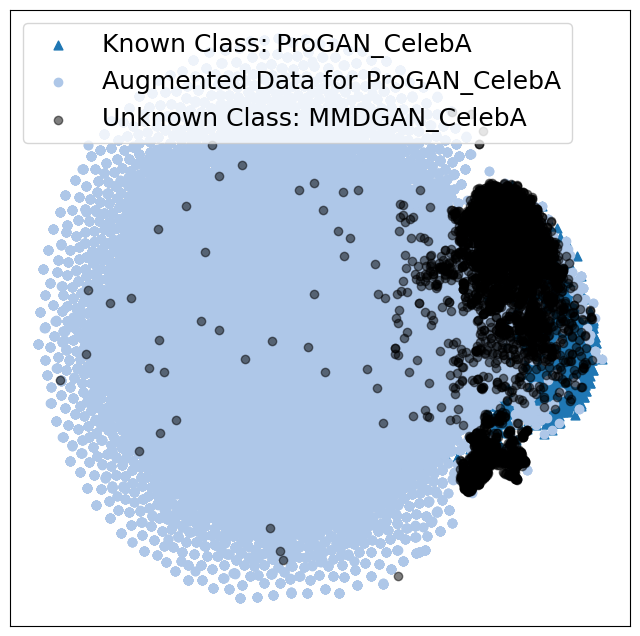

In [13]:
known_data_path = '/mnt/workspace/POSE/dataset/T2I/stable_diffusion_v15/train'
unknown_data_path = '/mnt/workspace/POSE/dataset/T2I/stable_diffusion_xl/train'
legends = ['Known Class: ProGAN_CelebA', 'Augmented Data for ProGAN_CelebA', 'Unknown Class: MMDGAN_CelebA']
case_visualization(known_data_path, unknown_data_path, legends)